Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [4]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
from sklearn.preprocessing import StandardScaler
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

In [5]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column, "New_cases_30_days_ago"]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

In [6]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(
    df, n_future, n_past, train_test_split_percentage, validation_split_percentage
):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past : i, 0:n_feature])
        y_data.append(df[i + n_future - 1 : i + n_future, 0])

    split_training_test_starting_point = int(
        round(train_test_split_percentage * len(x_data))
    )
    split_train_validation_starting_point = int(
        round(split_training_test_starting_point * (1 - validation_split_percentage))
    )

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]
    y_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return (
        np.array(x_train),
        np.array(x_test),
        np.array(x_val),
        np.array(y_train),
        np.array(y_test),
        np.array(y_val),
    )

In [8]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(1420, 2)

In [9]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=30,
    train_test_split_percentage=0.9,
    validation_split_percentage=0,
)

In [6]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(
    LSTM(
        units=16,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(
    optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1216      
                                                                 
 dropout (Dropout)           (None, 30, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3345 (13.07 KB)
Trainable params: 3345 (13.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(
    X_train, y_train, validation_split=0.3, epochs=200, batch_size=64, callbacks=[es]
)

Epoch 1/200
14/14 [==============================] - 3s 50ms/step - loss: 1.2805 - root_mean_squared_error: 1.1316 - val_loss: 0.6785 - val_root_mean_squared_error: 0.8237
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 0.7081 - root_mean_squared_error: 0.8415 - val_loss: 0.5102 - val_root_mean_squared_error: 0.7143
Epoch 3/200
14/14 [==============================] - 0s 10ms/step - loss: 0.4976 - root_mean_squared_error: 0.7054 - val_loss: 0.3394 - val_root_mean_squared_error: 0.5825
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 0.4362 - root_mean_squared_error: 0.6604 - val_loss: 0.2402 - val_root_mean_squared_error: 0.4901
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 0.4054 - root_mean_squared_error: 0.6367 - val_loss: 0.1731 - val_root_mean_squared_error: 0.4160
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: 0.3955 - root_mean_squared_error: 0.6289 - val_loss: 0.1341 - val_

In [8]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

5/5 [==============================] - 0s 9ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820
test loss, test acc: [0.0331 0.182 ]


In [9]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        # with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
        """''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        """ ""

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        """''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        """ ""

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )

        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [10]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [7, 28,365],
    [0.2],
]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)

[(True, True, True, 64, 7, 0.2), (True, True, True, 64, 28, 0.2), (True, True, True, 64, 365, 0.2), (True, True, True, 128, 7, 0.2), (True, True, True, 128, 28, 0.2), (True, True, True, 128, 365, 0.2), (True, True, True, 256, 7, 0.2), (True, True, True, 256, 28, 0.2), (True, True, True, 256, 365, 0.2), (True, True, False, 64, 7, 0.2), (True, True, False, 64, 28, 0.2), (True, True, False, 64, 365, 0.2), (True, True, False, 128, 7, 0.2), (True, True, False, 128, 28, 0.2), (True, True, False, 128, 365, 0.2), (True, True, False, 256, 7, 0.2), (True, True, False, 256, 28, 0.2), (True, True, False, 256, 365, 0.2), (True, False, True, 64, 7, 0.2), (True, False, True, 64, 28, 0.2), (True, False, True, 64, 365, 0.2), (True, False, True, 128, 7, 0.2), (True, False, True, 128, 28, 0.2), (True, False, True, 128, 365, 0.2), (True, False, True, 256, 7, 0.2), (True, False, True, 256, 28, 0.2), (True, False, True, 256, 365, 0.2), (True, False, False, 64, 7, 0.2), (True, False, False, 64, 28, 0.2), (Tr

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.11133

Epoch 3: val_loss improved from 0.11133 to 0.09034, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.09034

Epoch 5: val_loss did not improve from 0.09034

Epoch 6: val_loss did not improve from 0.09034

Epoch 7: val_loss improved from 0.09034 to 0.09020, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.09020

Epoch 9: val_loss did not improve from 0.09020

Epoch 10: val_loss did not improve from 0.09020

Epoch 11: val_loss did not improve from 0.09020

Epoch 12: val_loss did not improve from 0.09020
Epoch 12: early stopping
0-th combination = (True, True, True, 64, 7, 0.2) 
 train accuracy: [0.19989453256130219, 0.447095662355423] and test accuracy: [0.010091994889080524, 0.10045892000198364]
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.12117, saving model to best_model.h5

Epoch 2: val_loss did not improve 

In [11]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
70,False,False,False,256,28,0.2,"[0.2220999151468277, 0.4712747633457184]","[0.004538160283118486, 0.0673658698797226]"
58,False,False,True,128,28,0.2,"[0.17607398331165314, 0.41961169242858887]","[0.004558241926133633, 0.06751475483179092]"
37,False,True,True,64,28,0.2,"[0.27214863896369934, 0.5216786861419678]","[0.004757626447826624, 0.0689755529165268]"
5,True,True,True,128,365,0.2,"[0.2628646492958069, 0.5127032995223999]","[0.0048899040557444096, 0.06992784887552261]"
3,True,True,True,128,7,0.2,"[0.2556275427341461, 0.5055962204933167]","[0.004939476028084755, 0.07028140872716904]"
...,...,...,...,...,...,...,...,...
30,True,False,False,128,7,0.2,"[0.19196178019046783, 0.43813443183898926]","[0.09007427096366882, 0.30012375116348267]"
2,True,True,True,64,365,0.2,"[0.30010977387428284, 0.5478227734565735]","[0.10728481411933899, 0.32754361629486084]"
51,False,True,False,256,7,0.2,"[0.18810918927192688, 0.4337155520915985]","[0.11958440393209457, 0.34580978751182556]"
36,False,True,True,64,7,0.2,"[0.20644956827163696, 0.4543672204017639]","[0.13820649683475494, 0.37176135182380676]"


In [12]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)
print("**************************")
print(f"Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n")
print(f"Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n")
print(
    f"{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement"
)

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 256
 n_batch_size = 28
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.182

Results After Tunning:
 Test Set RMSE: 0.0674

63.0% Improvement


In [13]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = [False, True, False, 256, 7, 0.2]

In [14]:
list(hist.iloc[0, :-2])

[False, False, False, 256, 28, 0.2]

In [15]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.08876, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.08876

Epoch 3: val_loss did not improve from 0.08876

Epoch 4: val_loss did not improve from 0.08876

Epoch 5: val_loss did not improve from 0.08876

Epoch 6: val_loss did not improve from 0.08876
Epoch 6: early stopping


In [16]:
regressor.evaluate(X_test, y_test)

5/5 [==============================] - 0s 71ms/step - loss: 0.0700


0.07000435888767242

In [13]:
y_pred = regressor.predict(X_test)

5/5 [==============================] - 1s 20ms/step


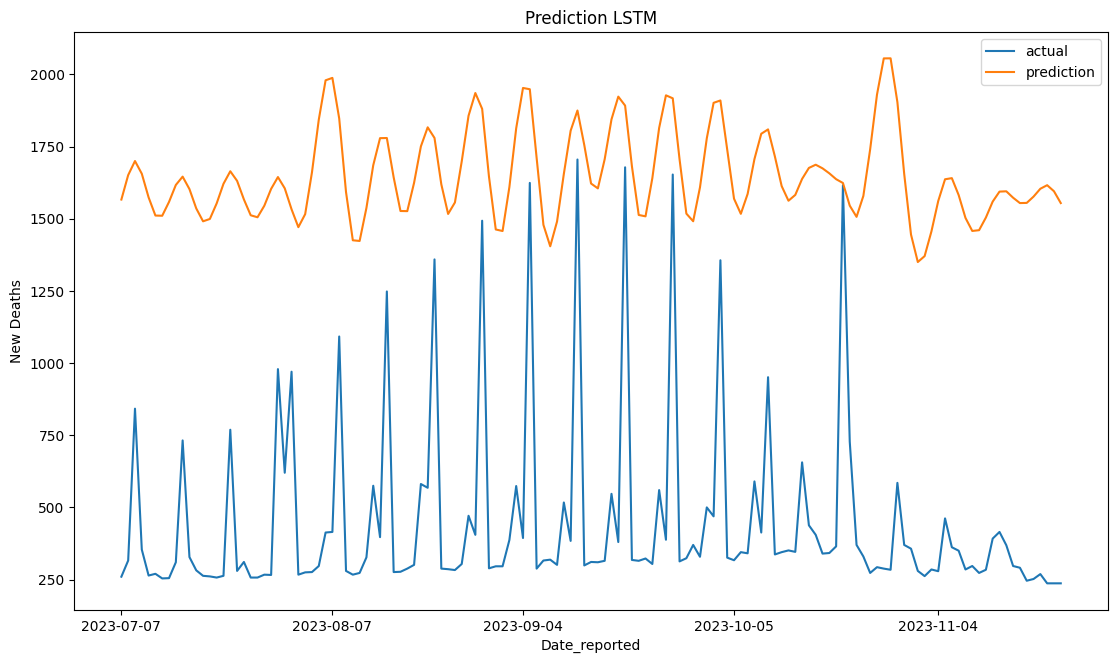

In [14]:
scaler = StandardScaler()
scaler.fit(df[[target_column]])
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]

import matplotlib.dates as mdates
data_length = len(unscaled_y_test)

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[-data_length:], unscaled_y_test, label="actual")
ax.plot(dates[-data_length:], unscaled_y_pred, label="prediction")
ax.set_title("Prediction LSTM")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [15]:
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test)

Evaluation Metrics:
MSE: 1520387.18
RMSE: 1233.04
MAE: 1198.16
MAPE: 358.21
SMAPE: 120.19


In [11]:
store_model(regressor, "lstm")